# Анализ активности студентов в чатах Яндекс Практикума

## Описание проекта

- **Заказчик исследования** — Яндекс Практикум.
- **Проблема** – Низкая обратная связь студентов на важные посты/анонсы, публикуемые в чатах.
- **Задача** - Определить, когда лучше публиковать посты/анонсы, чтобы получить больше откликов. 

Для того, что выполнить поставленную задачу необходимо: проанализировать динамику поведения студентов в чатах, с учетом наличия различных каналов и когорт, в течение дня, недели, месяца, года; найти и проанализировать зависимость между количеством откликов и временем публикации поста.

Для проведения анализа были использованы данные из чатов Пачки и Слака.

## Описание данных
- `Unnamed: 0` - индекс
- `client_msg_id` - id сообщения
- `type` - тип поста
- `user` - id пользователя 
- `ts` - дата поста
- `latest_reply` - дата ответа
- `team` - факт вхождения в неизветсную группу
- `thread_ts` - дата треда
- `subtype` - метка действий пользователя
- `channel` - канал
- `file_date` - дата файла
- `attachments` - прикрепленные файлы
- `reactions` - реакции
- `text_len` - длинна текста сообщения
- `text_words` - количество слов в сообщении

## Загрузка и предобрабокта данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import re
import json

In [2]:
pth1_data = 'chat_data_clean.csv'

# сюда можно ввести ваш адрес к датасету
pth2_data = ''

try:
    data = pd.read_csv(pth1_data)
except FileNotFoundError:
    data = pd.read_csv(pth2_data)
except:
    print('Something is wrong')

In [3]:
display(data.info(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26533 entries, 0 to 26532
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26533 non-null  int64  
 1   client_msg_id  18262 non-null  object 
 2   type           26533 non-null  object 
 3   user           23643 non-null  object 
 4   ts             26533 non-null  float64
 5   latest_reply   2303 non-null   float64
 6   team           15857 non-null  object 
 7   thread_ts      18222 non-null  float64
 8   subtype        8317 non-null   object 
 9   channel        26533 non-null  object 
 10  file_date      26533 non-null  object 
 11  attachments    26533 non-null  int64  
 12  reactions      4169 non-null   object 
 13  text_len       26533 non-null  int64  
 14  text_words     26533 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 3.0+ MB


None

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,1.669643e+09,1.669645e+09,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,1.669645e+09,NaN,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63
2,2,NaN,message,U02KVQJHQ5S,1.669647e+09,NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,1.669709e+09,1.669719e+09,NaN,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12
4,4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,1.669711e+09,NaN,TPV9DP0N4,1.669709e+09,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


In [4]:
# удалим столбец, дублирующий индексы
data = data.drop(columns = ['Unnamed: 0'],axis = 1)

# столбцы с датами приведем к типу datetime
data['ts'] = pd.to_datetime(data['ts'], unit='s').dt.round('1min')
data['latest_reply'] = pd.to_datetime(data['latest_reply'], unit='s').dt.round('1min')
data['thread_ts'] = pd.to_datetime(data['thread_ts'], unit='s').dt.round('1min')
data['file_date'] = pd.to_datetime(data['file_date'])

# проверим данные на наличие дубликатов
display(data.duplicated().sum())

807

In [5]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

# проверим данные на наличие неявных дубликатов
display(data['type'].unique(), data['team'].unique(), 
        data['subtype'].unique(), data['channel'].unique(), data['attachments'].unique(), data['reactions'].unique())

# неявных дубликатов нет

array(['message'], dtype=object)

array(['TPV9DP0N4', nan], dtype=object)

array([nan, 'channel_join', 'bot_remove', 'thread_broadcast',
       'channel_unarchive', 'channel_leave', 'bot_message',
       'channel_purpose', 'tombstone', 'channel_name'], dtype=object)

array(['data-analysts-bus', 'datatracker_logs', 'data_complaints',
       'data_edteam_info', 'da_42_exerciser_1', 'da_42_exerciser_2',
       'da_42_projects_1', 'da_42_projects_2', 'da_50_info',
       'da_50_library', 'da_50_teamwork', 'da_52_exerciser', 'da_52_info',
       'da_52_library', 'da_52_projects', 'da_52_teamwork',
       'da_53_exerciser_1', 'da_53_exerciser_2', 'da_53_info',
       'da_53_library', 'da_53_projects_1', 'da_53_projects_2',
       'da_53_teamwork', 'da_54_exerciser_01', 'da_54_exerciser_02',
       'da_54_info', 'da_54_library', 'da_54_projects_01',
       'da_54_projects_02', 'da_54_teamwork', 'da_55_exerciser',
       'da_55_info', 'da_55_library', 'da_55_projects', 'da_55_teamwork',
       'da_56b_exerciser', 'da_56b_info', 'da_56b_library',
       'da_56b_projects', 'da_56b_teamwork', 'da_56_exerciser_1',
       'da_56_exerciser_2', 'da_56_info', 'da_56_library',
       'da_56_projects_1', 'da_56_projects_2', 'da_56_teamwork',
       'da_58_digitalpro

array([0, 1, 2, 3, 4, 5], dtype=int64)

array([nan, "[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",
       ..., "[{'name': 'pray', 'users': ['U03RSC0RSBU'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U02QK4VR38F'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U044T2TLGH3'], 'count': 1}]"],
      dtype=object)

In [6]:
# проверим данные на наличие пропусков
display(data.isna().sum())

client_msg_id     7464
type                 0
user              2083
ts                   0
latest_reply     23424
team              9869
thread_ts         7505
subtype          18216
channel              0
file_date            0
attachments          0
reactions        21567
text_len             0
text_words           0
dtype: int64

Краткий анализ пропусков:
- `client_msg_id` - id постов уникальны, соответственно заполнить пропуски в этом столбце мы не сможем.
- `user` - Предположить кто из пользователей написал конкртеный пост мы не можем, поэтому не сможем и заполнить пропуски в этом столбце.
- `latest_reply` - Пропуски в этом столбце, вероятно, говорят нам о том, что на посты, с пропущенным latest_reply, никто не ответил. Оставим этот столбец без изменений.
- `team` - Пропуски в этом столбце, говорят нам об отсутствии факта вхождения поста в некую группу. Заменим значения 'TPV9DP0N4' и пропуски в этом столбце на значения 1 и 0 соответственно. 
- `thread_ts` - Пропуски в этом столбце, вероятно, говорят нам о том, что к постам, с пропущенным thread_ts, никто не создал тред. Оставим этот столбец без изменений.
- `subtype`- Восстановить данные о метках постов без текста этих постов мы не можем, поэтому не сможем и заполнить пропуски в этом столбце.
- `reactions` - Восстановить данные о реакциях на посты мы никак не можем, поэтому не сможем и заполнить пропуски в этом столбце.

In [7]:
# обработка пропусков
data['team'] = data['team'].fillna(0)
data.loc[data['team'] == 'TPV9DP0N4', 'team'] = 1

# оценим наличие аномалий в данных
display(data.describe())

# аномальных значений нет

,attachments,text_len,text_words
count,25726.000000,25726.000000,25726.000000
mean,0.009951,157.920120,21.055819
std,0.119189,246.007341,31.235366
min,0.000000,0.000000,0.000000
25%,0.000000,37.000000,5.000000
50%,0.000000,80.000000,11.000000
75%,0.000000,184.000000,25.000000
max,5.000000,10933.000000,989.000000


In [8]:
# выделим названия каналов в чатах
# для этого напишем функцию,принимающую на вход значения столбца channel и возвращающую название канала
def cohort_name(name):
    pat_1 = r'(^[a-z]{2}_\d{2}_\d_)|(^[a-z]{2}_\d{2}_)|(^[a-z]{2}_\d{2}[a-z]_)|(^[a-z]{2}_[a-z]{2}_\d{2}_)|(^[a-z]{2}_\d_)|'
    pat_2 = r'(^[a-z]{2}_[a-z]{4}_\d{2}_)|(^[a-z]{2}_[a-z]{4}_\d_)|'
    pat_3 = r'(_\d{2}[a-z]{2}_[a-z]{4}$)|(_\d[a-z]{2}_[a-z]{4}$)|(sql)|'
    pat_4 = r'(_\d{2}[a-z][а-я]_[a-z]{4}$)|(_\d[a-z][а-я]_[a-z]{4}$)' 
    result = re.search(pat_1+pat_2+pat_3+pat_4, str(name))
    try: result = result.group(0).strip('_')
    except:  
        result = 'unknown'
    return result

In [9]:
# применим нашу функцию к датасету
data['cohort'] = data['channel'].apply(cohort_name)

In [12]:
# доработаем столбец с названиями когорт
data.loc[data['cohort'] == '10ds_plus',  'cohort'] = 'ds_plus_10' 
data.loc[data['cohort'] == '10dа_plus',  'cohort'] = 'da_plus_10' 
data.loc[data['cohort'] == '11ds_plus',  'cohort'] = 'ds_plus_11'
data.loc[data['cohort'] == '11dа_plus',  'cohort'] = 'da_plus_11' 
data.loc[data['cohort'] == '12ds_plus',  'cohort'] = 'ds_plus_12' 
data.loc[data['cohort'] == '7ds_plus',  'cohort'] = 'ds_plus_07'
data.loc[data['cohort'] == '8ds_plus',  'cohort'] = 'ds_plus_08'
data.loc[data['cohort'] == '8dа_plus',  'cohort'] = 'da_plus_08'
data.loc[data['cohort'] == '9ds_plus',  'cohort'] = 'ds_plus_09'
data.loc[data['cohort'] == '9dа_plus',  'cohort'] = 'da_plus_09'

In [13]:
# из полученного столбца выделим отдельно названия специальностей студентов
# для этого напишем функцию,принимающую на вход значения столбца cohort и возвращающую сокращенное название специальности
def cohort_name_prof(name):
    pat_1 = r'(sql)|(unknown)|(^[a-z]{2})'
    result = re.search(pat_1, str(name))
    try: result = result.group(0)
    except:  
        result = 'unknown'
    return result

In [14]:
# применим нашу функцию к датасету
data['cohort_profile'] = data['cohort'].apply(cohort_name_prof)

In [15]:
# выделим названия студенческих когорт
# для этого напишем функцию,принимающую на вход значения столбца channel и возвращающую название когорты
def channel_separate(name):
    pat_1 = r'(info)|(_[a-z]{5,})|(^[a-z]{10,}_)'
    result = re.search(pat_1, str(name))
    try: result = result.group(0).strip('_')
    except:  
        result = 'unknown'
    return result

In [16]:
# применим нашу функцию к датасету
data['channel_sep'] = data['channel'].apply(channel_separate)

In [17]:
# доработаем названия каналов
data.loc[data['channel_sep'] == 'project',  'channel_sep'] = 'projects'
usefull_channel = ['exerciser', 'projects', 'info', 'library', 'teamwork', 'masterskaya']
data['channel_sep'] = data['channel_sep'].where(data['channel_sep'].isin(usefull_channel), 'unknown')

In [18]:
# выделим дни недели, часы, номера дней, недель, месяцев и года из даты создания каждого поста

data['weekday'] = data['ts'].dt.day_name()
data['hour'] = data['ts'].dt.hour
data['day'] = data['ts'].dt.day
data['week'] = data['ts'].dt.isocalendar().week
data['month'] = data['ts'].dt.month 
data['year'] = data['ts'].dt.year

In [19]:
# выделим количество реакций к каждому посту
# для этого напишем функцию,принимающую на вход значения столбца reactions и возвращающую количество реакций
def count_reaction(name):
    try:
        name = json.loads(name.replace("'",'"'))
        if type(name) == dict:
            result = name.get('count')
        elif type(name) == list:
            result = 0
            for ddict in name:
                if type(ddict) == dict:
                    values = ddict.get('count')
                    result += values
                else:
                    result = 'error'
        else:
            result = 'error'
    except:  
        result = 0
    return result    

In [20]:
# применим нашу функцию к датасету 
data['reactions_count'] = data['reactions'].apply(count_reaction)

In [21]:
# сделаем срез данных, удалив посты, на которые студенты не могут ответить или поставить реакции; это посты, которые 
# месенджеры создают автоматически, например, при присоединении нового пользователя к каналу; такие посты, отмечены метками:
# 'channel_join', 'channel_unarchiver', 'channel_leave', 'channel_purpose', 'channel_name'

auto_msg = ['channel_join', 'channel_unarchiver', 'channel_leave', 'channel_purpose', 'channel_name']
slice_data = data[~ data['subtype'].isin(auto_msg)]

## Анализ данных

### Общий анализ активности студентов в чатах
Студенты могут проявлять активность в чатах тремя способами:
- создавать посты;
- комментировать посты;
- оставлять реакции к постам.

Но не все вышеперечисленные варианты применимы для нашего исследования. Так, количество комментариев мы посчитать не можем, ввиду нехватки исходных данных; в каналах *info*, *exerciser*, *projects* студентам нельзя создавать посты, а каналы *library*, *teamwork*, наоборот, созданы для того, чтобы в них студенты общались между собой. Исходя из этого будем оценивать активность студентов по разному:
- Для каналов 'info', 'exerciser', 'projects' будем оценивать активность студентов по количеству реакций.
- Для каналов 'library', 'teamwork', 'masterskaya' будем оценивать активность студентов по количеству реакций и количеству созданных постов.

#### Каналы: info, exerciser и projects

In [22]:
# построим графики активности студентов в каналах 'info', 'exerciser', 'projects'
# по дням недели,часам, дням месяца, неделям, месяцам и годам 
channel_1 = ['info', 'exerciser', 'projects']
slice_data_1 = slice_data.query('channel_sep in @channel_1')
add =['дням недели', 'часам', 'дням месяца', 'неделям', 'месяцам', 'годам' ]
ts = ['weekday', 'hour', 'day', 'week', 'month', 'year']

# напишем соответствующую функцию
def report_barplot(report, ts, add, reactions='reactions_count', msg='type'):
    report_1 = report.pivot_table(index=ts, values=reactions, aggfunc='sum').reset_index() 
    report_1.columns = [ts, reactions]
    report_1  = report_1.sort_values(by=reactions, ascending=False)
    
    #график сравнения
    report_2 = report.pivot_table(index=ts, values=msg, aggfunc='count').reset_index() 
    report_2.columns = [ts, 'msg_count']
    report_2  = report_2.sort_values(by='msg_count', ascending=False)    
    
    sns.set_palette('pastel')
    sns.despine()
    plt.figure(figsize=(9, 10))
    
    plt.subplot(2, 1, 1)
    fig = sns.barplot(x=ts, y=reactions, data=report_1, color='lightgreen')
    fig.set_title('Распределение количества реакций по '+add)
        
    plt.subplot(2, 1, 2)
    fig = sns.barplot(x=ts, y='msg_count', data=report_2, color='yellow')
    fig.set_title('Распределение количества постов по '+add)
    
    plt.show();

<Figure size 432x288 with 0 Axes>

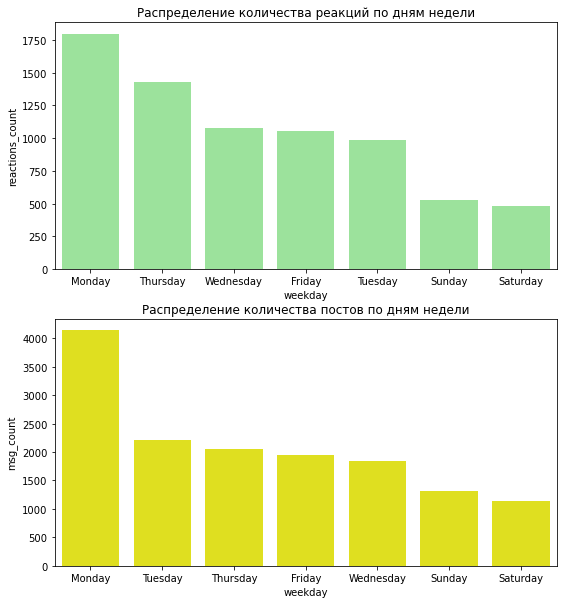

In [23]:
report_barplot(slice_data_1, ts[0], add[0])

Наибольшее число реакций набрали посты, опубликованные в понедельник, наименьшее - в выходные дни. Интересно здесь то, что по четвергам публикуется почти столько же постов, как и во вторник, среду или пятницу. Однако, эти посты собрали больше реакций.

<Figure size 432x288 with 0 Axes>

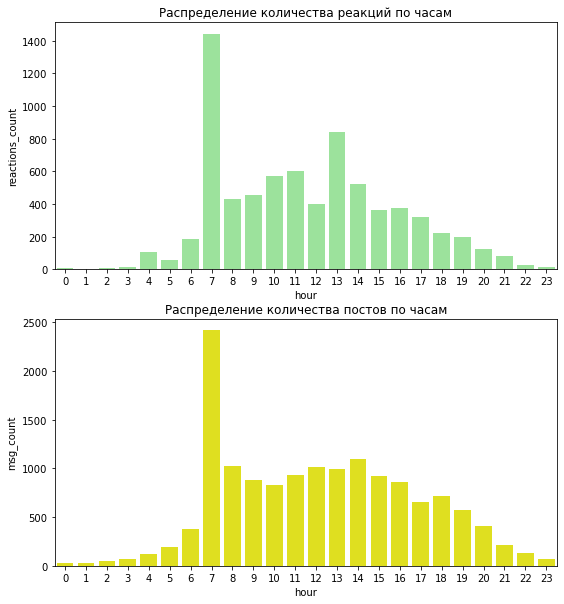

In [24]:
report_barplot(slice_data_1, ts[1], add[1])

Наибольшее число реакций набрали посты, опубликованные в утренние часы 7:00, второй пик количества реакций приходится на посты, опубликованные в 13:00. Интересно здесь то, что в 13:00 публикуется среднее количество постов, относительно обеденного времени. Однако, посты опубликованные в это время собрали больше реакций.

<Figure size 432x288 with 0 Axes>

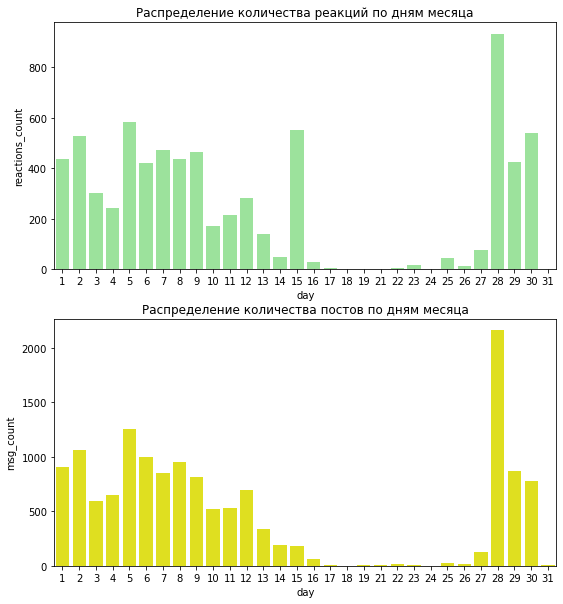

In [25]:
report_barplot(slice_data_1, ts[2], add[2])

Наибольшее число реакций набрали посты, опубликованные 28 числа, второй выделяющийся пик приходятся на посты, опубликованные 15 числа. Интересно здесь то, что 15 числа публикуется мало постов. Однако, эти посты собирают большое количество реакций.

<Figure size 432x288 with 0 Axes>

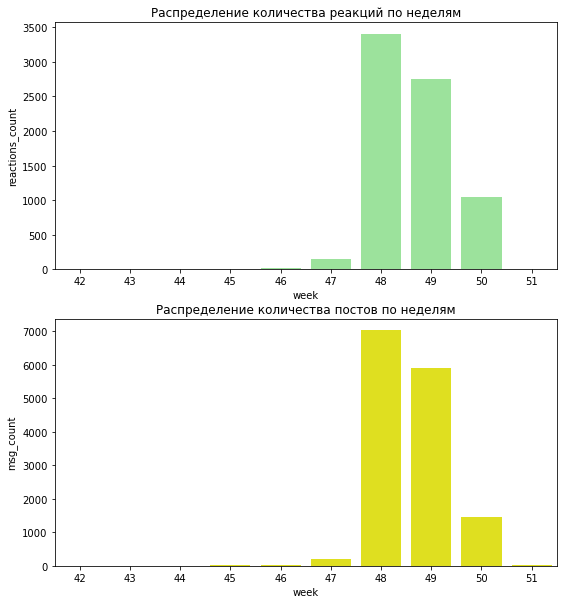

In [26]:
report_barplot(slice_data_1, ts[3], add[3])

Наибольшее число реакций набрали посты, опубликованные на 48 неделе. Из интересных особенностей здесь то, что активность студентов на 47 и 48 неделях очень сильно различается между собой. Возможно, что в датасет попала информация только о конце 47 недели, что вызвало такой большой разрыв в количестве данных.

<Figure size 432x288 with 0 Axes>

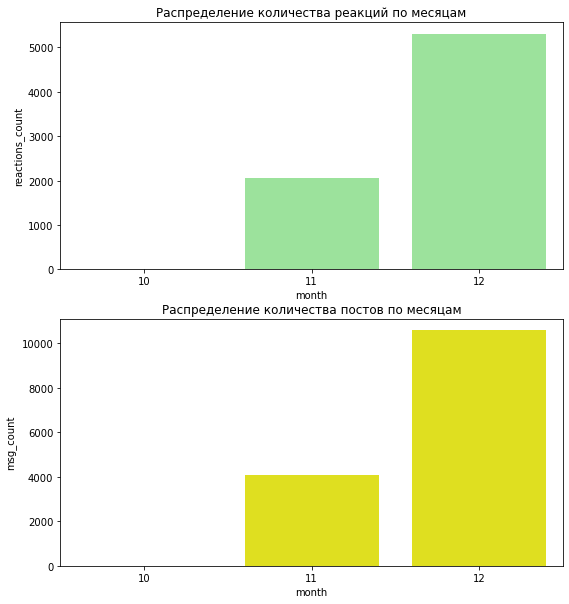

In [27]:
report_barplot(slice_data_1, ts[4], add[4])

Наибольшее число реакций набрали посты, опубликованные в декабре. Из интересных особенностей здесь то, что перед новым годом активность каналов возрасла.

<Figure size 432x288 with 0 Axes>

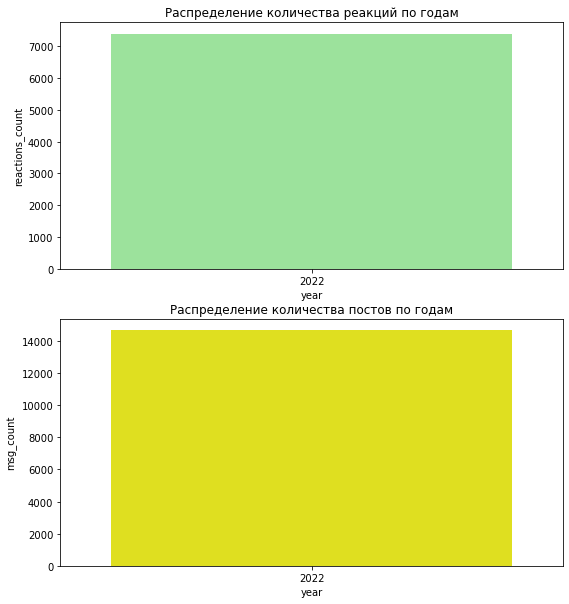

In [28]:
report_barplot(slice_data_1, ts[5], add[5])

Здесь мы узнали, что данные собраны за 2022 год. Интересных особенностей нет.

#### Каналы: library, teamwork, masterskaya

In [29]:
# построим графики активности студентов в каналах 'library', 'teamwork', 'masterskaya'
# по наиболее интересным параметрам: дням недели,часам, дням месяца
channel_2 = ['library', 'teamwork', 'masterskaya']
slice_data_2 = slice_data.query('channel_sep in @channel_2')
add =['дням недели', 'часам', 'дням месяца', 'неделям', 'месяцам', 'годам' ]
ts = ['weekday', 'hour', 'day', 'week', 'month', 'year']

# напишем соответствующую функцию
def report_barplot_with_posts(report, ts, add, reactions='reactions_count', msg='type'):
    report_1 = report.pivot_table(index=ts, values=reactions, aggfunc='sum').reset_index() 
    report_1.columns = [ts, reactions]
    report_1  = report_1.sort_values(by=reactions, ascending=False)
    
    report_2 = report.pivot_table(index=ts, values=msg, aggfunc='count').reset_index() 
    report_2.columns = [ts, 'msg_count']
    report_2  = report_2.sort_values(by='msg_count', ascending=False)    
    
    sns.set_palette('pastel')
    sns.despine()
    plt.figure(figsize=(9, 10))
    
    plt.subplot(2, 1, 1)
    fig = sns.barplot(x=ts, y=reactions, data=report_1, color='lightgreen')
    fig.set_title('Распределение количества реакций по '+add)
    
    plt.subplot(2, 1, 2)
    fig = sns.barplot(x=ts, y='msg_count', data=report_2, color='lightgreen')
    fig.set_title('Распределение количества постов по '+add)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

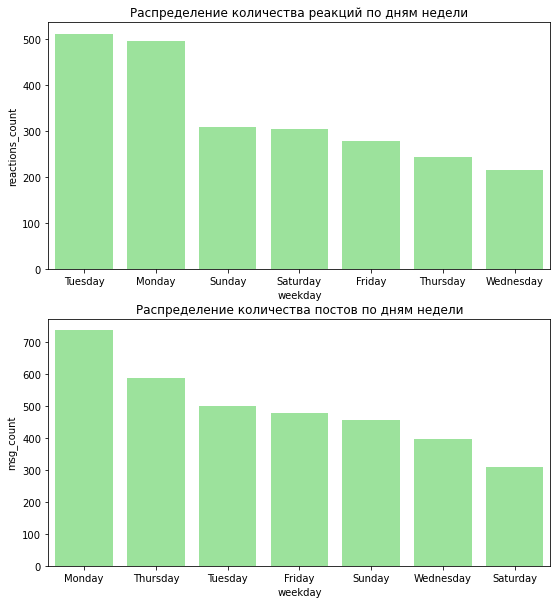

In [30]:
report_barplot_with_posts(slice_data_2, ts[0], add[0])

Наибольшее число реакций набрали посты, опубликованные во вторник, наименьшее - в среду. Интересно здесь то, что в понедельник сами студенты публикуют наибольшее количество постов. Таким образом, понедельник - самый активный день и для команды я.практикума и для студентов. 

<Figure size 432x288 with 0 Axes>

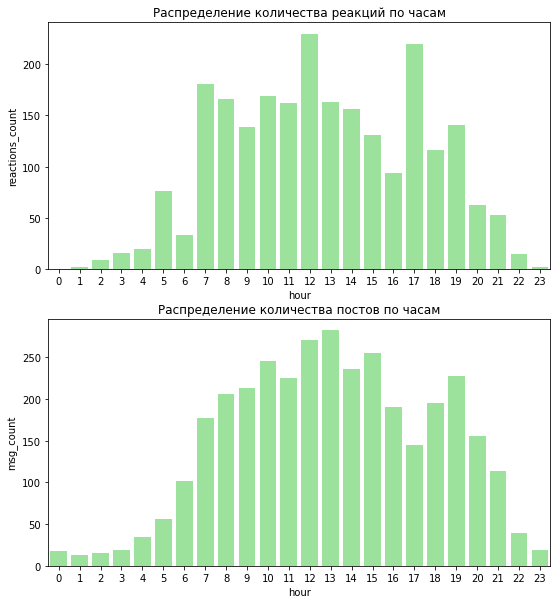

In [31]:
report_barplot_with_posts(slice_data_2, ts[1], add[1])

Наибольшее число реакций набрали посты, опубликованные в 12 часов, второй пик приходится на посты, опубликованные в 17 часов. Интересно здесь то, в 7 утра у студентов не наблюдается пик активности, несмотря на то, что в основных каналах публикуется большое количество постов.

<Figure size 432x288 with 0 Axes>

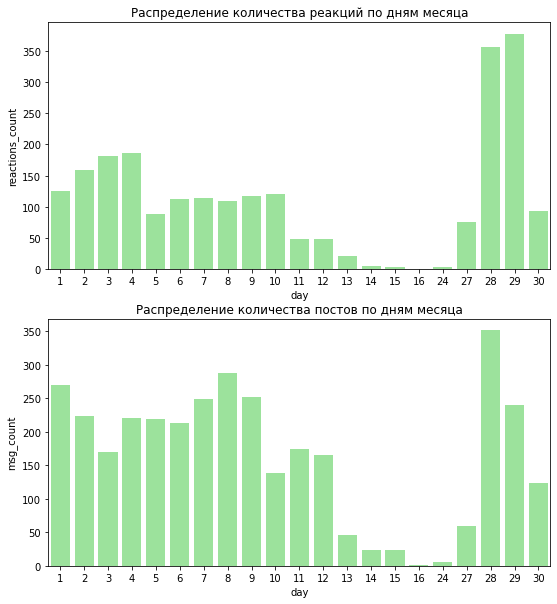

In [32]:
report_barplot_with_posts(slice_data_2, ts[2], add[2])

Наибольшее число реакций набрали посты, опубликованные 28-29 числа. Интересно здесь то, что пик активности 28 числа совпадает с пиком активности основных каналов. 

### Анализ активности студентов в чатах с разбивкой по когортам

#### Каналы: info, exerciser и projects

In [33]:
# построим графики активности студентов в каналах 'info', 'exerciser', 'projects'
# по наиболее интересным параметрам: дням недели,часам, дням месяца
# напишем соответствующую функцию
def report_plot(report, ts, add, reactions='reactions_count', cohort='cohort_profile', msg='type'):
    report_1 = report.pivot_table(index=[ts, cohort], values=reactions, aggfunc='sum').reset_index()
    report_1.columns = [ts, 'cohort', 'reactions_count']
    report_1  = report_1.sort_values(by=reactions, ascending=False)

    # график сравнения
    report_2 = report.pivot_table(index=[ts, cohort], values=msg, aggfunc='count').reset_index()    
    report_2.columns = [ts, 'cohort', 'msg_count']
    report_2  = report_2.sort_values(by='msg_count', ascending=False)    

    sns.set_palette('pastel')
    sns.despine()
    plt.figure(figsize=(16, 10))
    plt.grid(color='grey', lw=0.25)

    plt.subplot(2, 1, 1)
    fig = sns.barplot(x=ts, y=reactions, hue='cohort', data=report_1)
    fig.set_title('Распределение количества реакций по '+add)
    
    plt.subplot(2, 1, 2)
    fig = sns.barplot(x=ts, y='msg_count', hue='cohort', data=report_2)
    fig.set_title('Распределение количества постов по '+add)
    
    plt.show();

<Figure size 432x288 with 0 Axes>

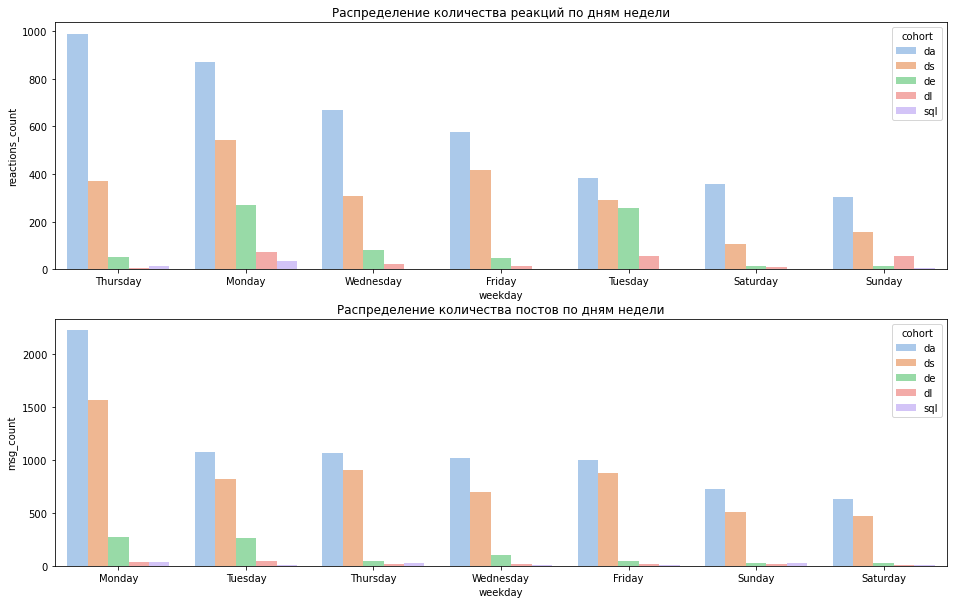

In [34]:
report_plot(slice_data_1, ts[0], add[0])

Наибольшее число постов генерируется в когортах da. Следом за ними, с небольшим отставанием, идут когорты ds. Наибольшее число реакций набрали посты, опубликованные в когортах da в четверг. Интересно здесь то, что в четверг в когортах da было опубликовано немного постов, однако, эти посты, опубликованные в этот день набрали рекордное количество реакций. 

<Figure size 432x288 with 0 Axes>

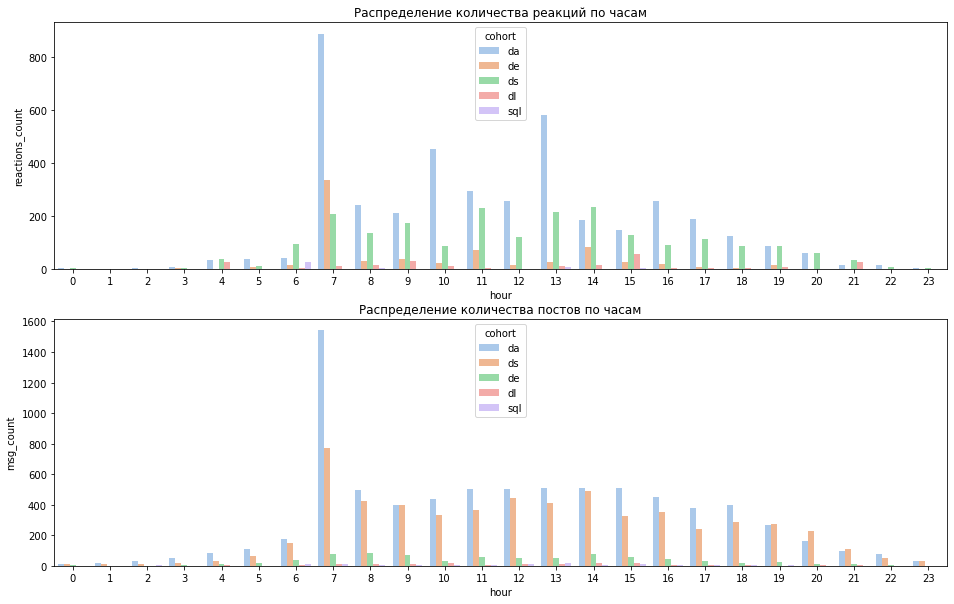

In [35]:
report_plot(slice_data_1, ts[1], add[1])

Интересно здесь то, что в 10:00 и в 13:00 в когортах da публикуется среднее количество постов. Однако, посты опубликованные в это время собрали большое количчество реакций.

<Figure size 432x288 with 0 Axes>

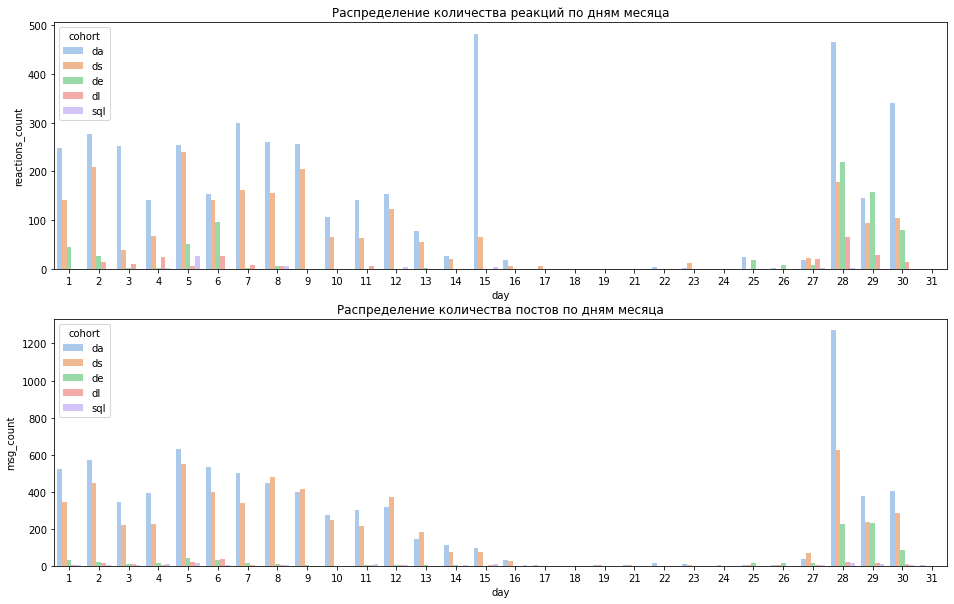

In [36]:
report_plot(slice_data_1, ts[2], add[2])

Интересно здесь то, что 15 и 30 числа в когортах da публикуется мало постов. Однако, эти посты собирают большое количество реакций.

#### Каналы: library, teamwork, masterskaya

<Figure size 432x288 with 0 Axes>

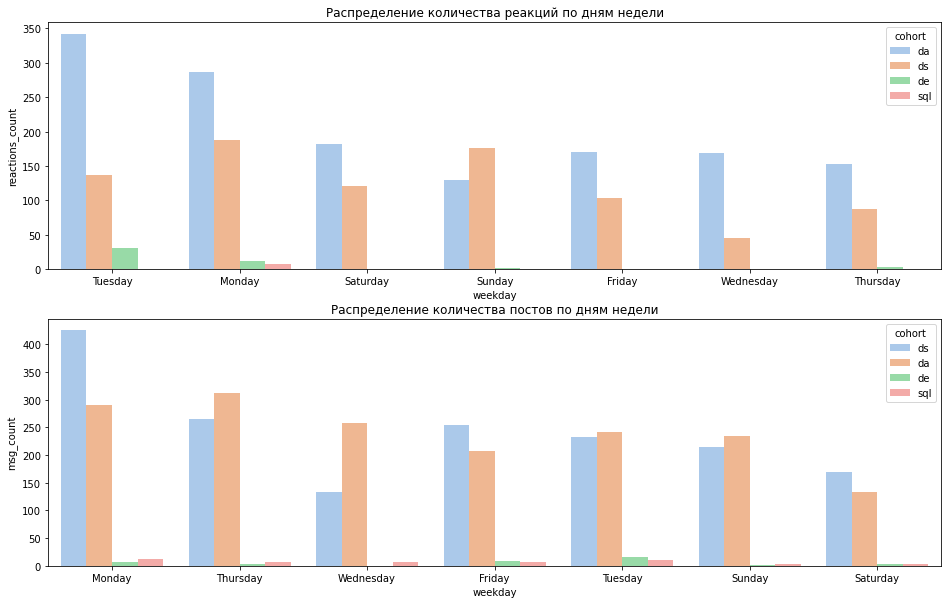

In [37]:
report_plot(slice_data_2, ts[0], add[0])

Наибольшее число постов генерируется в когортах da и ds. Наибольшее число реакций набрали посты, опубликованные в когортах da в четверг. Интересно здесь то, что пик активности в публикации постов приходится на понедельник для когорт ds и, соответственно, на четверг для когорт da.

<Figure size 432x288 with 0 Axes>

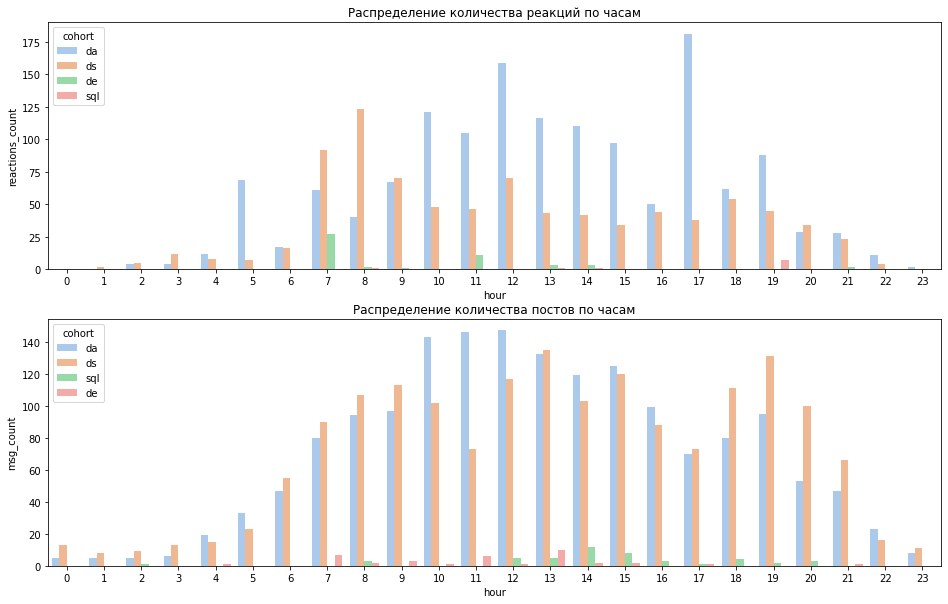

In [38]:
report_plot(slice_data_2, ts[1], add[1])

Интересно здесь то, что с 10 до 12 часов сами студенты когорт da публикуют большое количество постов. Пик активности в 7 утра не наблюдается ни у когорт da, ни у когорт ds.

<Figure size 432x288 with 0 Axes>

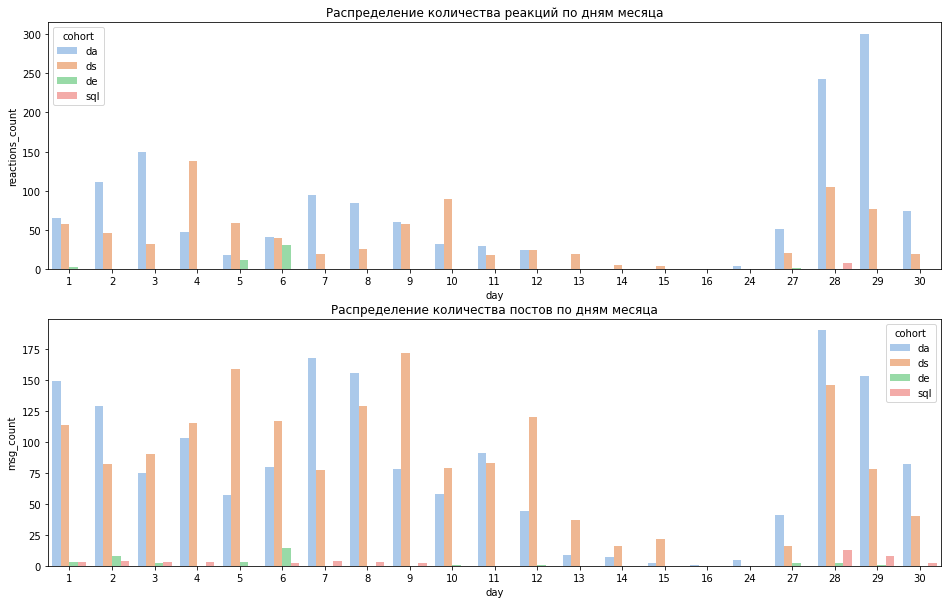

In [39]:
report_plot(slice_data_2, ts[2], add[2])

Интересно здесь то, что пики активности в публикации постов 28, 29 числа не намного больше пиков 8, 9 числа.

### Анализ активности студентов в чатах когорт da и ds

Исходя из уже проведенного анализа мы видим, что большая часть реакций и постов принадлежит студентам из когорт da и ds. Проведем для них более детальный анализ для наиболее интересных нам каналов **info**, **exerciser** и **projects**.

In [51]:
# построим графики активности студентов когорт da и ds в каналах 'info', 'exerciser', 'projects'
# по наиболее интересным параметрам: дням недели,часам, дням месяца
profile = ['da', 'ds']
slice_data_3 = slice_data.query('channel_sep in @channel_1 & cohort_profile in @profile')

# напишем соответствующую функцию
def report_bar(report, ts, add, cohort='cohort', reactions='reactions_count'):
    report_1 = report.groupby([ts, cohort])[reactions].sum().reset_index()
    report_1.columns = [ts, cohort, reactions]
    report_1 = report_1.sort_values(by=reactions, ascending=False)
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=ts, y=reactions, hue=cohort, palette="Paired", dodge=False, data=report_1)
    ax.set_title('Распределение количества реакций по ' + add)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:10], labels[:10], loc='upper right')
    plt.show()

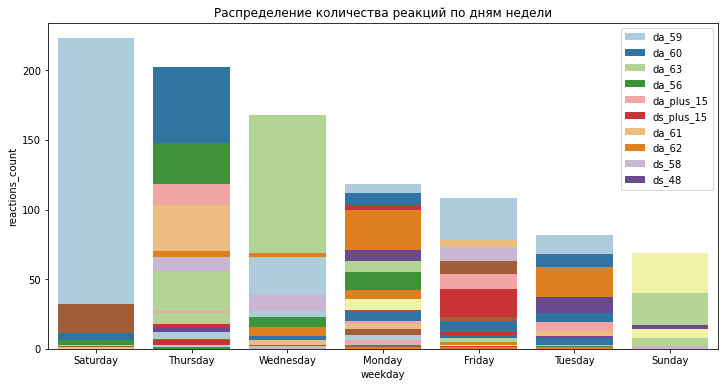

In [52]:
report_bar(slice_data_3, ts[0], add[0])

Студенты когорты da_59 наиболее активны. Интересно, что субботние посты в этой когорте собрали наибольшее количество реакций. Связано ли это с тем, что команда я.практикума этой когорты публикует большое количество постов именно в выходной день?

In [53]:
# найдем ответ на вопрос из предыдущего пункта
# для этого создадим таблицу, в которой будет отражено общее количество опубликованных постов с разбивкой по дням недели, 
# для когорты da_59
cohort = ['da_59']
slice_data_0 = slice_data_3.query('cohort in @cohort')
report_0 = slice_data_0.groupby(['weekday', 'cohort'])['type'].count().reset_index()
report_0.columns = ['weekday','cohort','msg_count']
report_0 = report_0.sort_values(by='msg_count', ascending=False)

display(report_0)

,weekday,cohort,msg_count
1,Monday,da_59,366
6,Wednesday,da_59,212
4,Thursday,da_59,208
5,Tuesday,da_59,206
0,Friday,da_59,195
2,Saturday,da_59,154
3,Sunday,da_59,129


Высокая активность студетов когорты da_59, проявляемая в отношении субботних постов, не связана с публикацией в этот день большого количества постов комнадой я.практикума. Итересная находка - ✓.

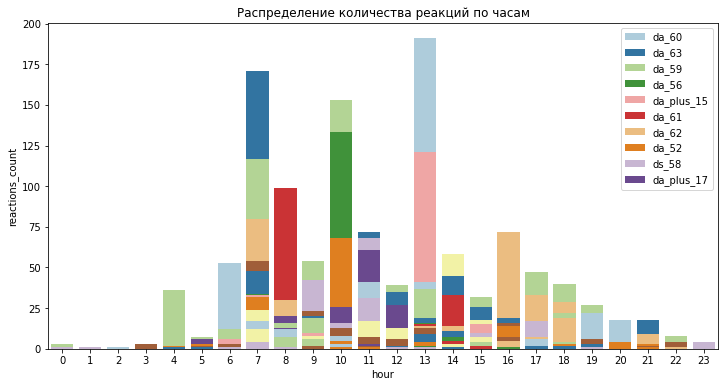

In [54]:
report_bar(slice_data_3, ts[1], add[1])

Наибольшее число реакций набрали посты, опубликованные в 7 часов, второй пик количества реакций приходится на посты, опубликованные в 13 часов.

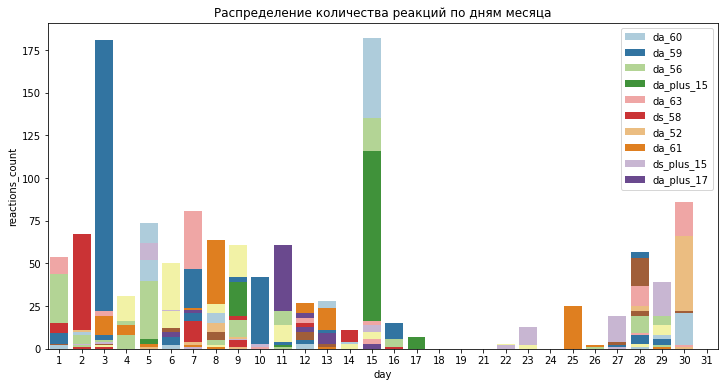

In [55]:
report_bar(slice_data_3, ts[2], add[2])

Наибольшее число реакций набрали посты, опубликованные 28 числа, второй выделяющийся пик количества реакций приходятся на посты, опубликованные 15 числа.

## Вывод

### Цель проведенного исследования

Определить, когда команде Яндекс Практикума лучше публиковать посты/анонсы, чтобы получить на них больше откликов. 


### Динамика активности студентов 

На основании анализа каналов library, teamwork, masterskaya, где студенты сами публикуют посты, мы получили зависимость  активности студентов от времени. В данном случае, активность студентов будет выражаться только публикацией постов, т.к. дата этого действия нам известна, в отличие от даты оставления реакций к постам. Рассмотрим эту динамику более детально.

- Большая часть данных представлена постами, сгенерированными в когортах da и ds.
- В понедельник активность в чатах наивысшая: в понедельник публикуется большое количество постов комнадой я.практикума, на которые студенты ставят реакции; больше постов - больше реакций. Однако, в понедельник на каналах library, teamwork, masterskaya сами студенты, тоже, публикуют большое количество постов. Таким образом, понедельник - самый активный день и для команды я.практикума и для студентов. 
- Высокая активность у студентов наблюдается в понедельник и четверг; во вторник, серду, пятницу и субботу - активность средняя, постепеннно снижающаяся. Самый низкий уровень активности - в воскресенье. У когорт da и ds провал активности просиходит в субботу.
- В течение дня активность студентов имеет нормальное распределение. Низкий уровень активности в ночное время, высокий в утренее и обеденное время; в вечернее время активность постепенно снижается. Интересно, что в 7 утра у студентов не наблюдается пик активности, несмотря на то, что в основных каналах публикуется большое количество постов. У когорт da пик активности приходится на время с 10 до 12 часов. Небольшой провал в активности виден около 16-17 часов.
- В течение месяца активность студентов средняя, иногда высокая в начале месяца; в середине месяца активность резко снижается и ее пик приходится на конец месяца - 28, 29 числа. 

Здесь следует отметить, что активность на каналах library, teamwork, masterskaya на порядок ниже, чем активность на каналах info, exerciser, projects, где посты публикует команда я.практикума. 

### Особенности зависимости количества откликов от времени публикации поста
 
На основании анализа каналов info, exerciser, projects мы получили зависимость количества реакций, оставленных к посту, от даты публикации этого поста. Рассмотрим особенности этой зависимости.

- По четвергам публикуется среднее количество постов. Однако, эти посты собирают больше реакций. 
- Около 13 часов публикуется среднее количество постов (относительно обеденного времени). Однако, посты опубликованные в этот промежуток времени собирают больше реакций. Для когорт da характерен еще один пик, в который посты получают большое количество реакций - около 10 часов.
- 15 числа публикуется очень мало постов. Однако, эти посты собирают большое количество реакций. Для когорт da характерен еще один пик, в который посты получают большое количество реакций - 30 число.

Здесь следует отметить временные интервалы, в которые уже команда я.практикума публикует большое количество постов, и для которых наблюдается прямо пропорциональное им большое количество реакций: 7 часов утра, понедельник, 28 число.


### Рекомендации 

Для того, чтобы определить наиболее удачное время для публикации постов необходимо учесть динамику активности студентов и зависимость количества откликов от времени пуликации поста.

- Наиболее удачные новые временные интервалы для публикации постов: около 13 часов, по четвергам, 15, 28, 29 числа.

### Интересная находка

- Субботние посты в когорте da_59 собрали рекордное количество реакций! Интересно, что высокая активность студетов, проявляемая в отношении субботних постов, не связана с публикацией в этот день большого количества постов комнадой я.практикума. Студенты оставили большое количество реакций на небольшое количество субботних постов. Что же это были за посты :)

### Что хотелось бы дополнительно изучить

- Динамику активности студентов в основных каналах info, exerciser, projects. Например, с помощью данных о времени оставления реакций к постам.
- Распределение количества студентов от когорты к когорте.
- Изменения активности студентов в рамках полного жизненного цикла когорты: со дня создания канала до завершения обучения.